<a href="https://colab.research.google.com/github/Satish-970/ATS_Checker_Job-Description/blob/main/ATS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATS Resume Matcher: Your Guide to a Better Resume

This tool evaluates how well your resume matches a job description, providing an ATS score and suggestions for improvement. It's designed to help you pass through Applicant Tracking Systems (ATS) and get your resume seen by recruiters.

To use it, run all the code cells sequentially. You'll be prompted to:
1. Upload your resume (PDF or DOCX) via a file upload dialog.
2. Paste the job description into an input box.
3. View the ATS score, keyword analysis, and suggestions directly in Colab.

**No sign-in required** - uploads are done directly from your local machine. 

### How to Run
1. Run the first cell to install dependencies.
2. Run the second cell to define the ATS functions.
3. Run the third cell to start the ATS checker, which will prompt for file upload and job description input.

**Note**: Ensure your resume is a text-based PDF or DOCX file (not a scanned image) for accurate text extraction.

In [35]:
# Step 1: Install and Import Libraries

# Install necessary libraries
!pip install spacy PyPDF2 python-docx scikit-learn matplotlib --quiet
!python -m spacy download en_core_web_sm --quiet

# Import libraries
import spacy
import PyPDF2
from docx import Document
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from google.colab import files
import os

print("Setup complete! ")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Setup complete! 


In [36]:
# Step 2: Define Core Functions

# Load the spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print("Downloading spaCy model...")
    !python -m spacy download en_core_web_sm --quiet
    nlp = spacy.load('en_core_web_sm')

# Function to extract text from PDF
def extract_pdf_text(pdf_path):
    text = ''
    try:
        with open(pdf_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page in reader.pages:
                extracted_page_text = page.extract_text()
                if extracted_page_text:
                    text += extracted_page_text + ' '
    except Exception as e:
        print(f"Error extracting text from PDF: {e}")
        return ""
    return text.strip()

# Function to extract text from DOCX
def extract_docx_text(docx_path):
    text = ''
    try:
        doc = Document(docx_path)
        for paragraph in doc.paragraphs:
            text += paragraph.text + ' '
    except Exception as e:
        print(f"Error extracting text from DOCX: {e}")
        return ""
    return text.strip()

# Function to extract text from uploaded resume
def extract_resume_text(file_path):
    file_extension = file_path.lower().split('.')[-1]
    if file_extension == 'pdf':
        return extract_pdf_text(file_path)
    elif file_extension in ['docx', 'doc']:
        return extract_docx_text(file_path)
    else:
        print("Unsupported file format. Please upload PDF or DOCX files only. ")
        return ""

# Function to extract keywords
def extract_keywords(text):
    doc = nlp(text.lower())
    keywords = set()

    # Comprehensive list of technical and professional skills
    tech_skills = {
        'python', 'java', 'javascript', 'sql', 'html', 'css', 'react', 'angular',
        'vue', 'node.js', 'django', 'flask', 'spring', 'hibernate', 'mongodb',
        'postgresql', 'mysql', 'oracle', 'aws', 'azure', 'gcp', 'docker',
        'kubernetes', 'jenkins', 'git', 'github', 'gitlab', 'agile', 'scrum',
        'kanban', 'jira', 'confluence', 'tensorflow', 'pytorch', 'keras',
        'pandas', 'numpy', 'scipy', 'matplotlib', 'seaborn', 'tableau',
        'powerbi', 'excel', 'r', 'scala', 'spark', 'hadoop', 'kafka',
        'elasticsearch', 'redis', 'graphql', 'rest', 'api', 'microservices',
        'devops', 'ci/cd', 'linux', 'windows', 'macos', 'bash', 'powershell',
        'communication', 'leadership', 'teamwork', 'management', 'analytics',
        'problem-solving', 'debugging', 'testing', 'automation'
    }

    # Extract nouns, proper nouns, and technical skills
    for token in doc:
        if token.pos_ in ['NOUN', 'PROPN'] and len(token.text) > 2 and token.text.isalpha():
            keywords.add(token.text)
        elif token.text in tech_skills:
            keywords.add(token.text)

    # Handle multi-word skills and phrases
    text_lower = text.lower()
    multi_word_skills = [
        'machine learning', 'data analysis', 'data science', 'project management',
        'artificial intelligence', 'deep learning', 'natural language processing',
        'computer vision', 'big data', 'business intelligence', 'data mining',
        'software development', 'web development', 'mobile development',
        'full stack', 'front end', 'back end', 'database management',
        'cloud computing', 'cyber security', 'network security',
        'quality assurance', 'user experience', 'user interface'
    ]

    for skill in multi_word_skills:
        if skill in text_lower:
            keywords.add(skill)

    return keywords

# Function to calculate ATS score
def calculate_ats_score(resume_text, job_description):
    documents = [resume_text, job_description]
    vectorizer = TfidfVectorizer(
        stop_words='english',
        ngram_range=(1, 2),
        max_features=1000,
        lowercase=True
    )
    tfidf_matrix = vectorizer.fit_transform(documents)
    similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
    return similarity * 100

# Function to provide improvement suggestions
def get_suggestions(resume_keywords, job_keywords):
    missing = job_keywords - resume_keywords
    if missing:
        missing_list = sorted(list(missing))[:10]  # Top 10 suggestions
        return f"Consider adding these keywords to your resume: {', '.join(missing_list)} "
    return "Excellent! Your resume contains all the key skills from the job description. "

# Function to provide score interpretation
def get_score_feedback(score):
    if score >= 80:
        return "Excellent match! Your resume aligns very well with this job. "
    elif score >= 65:
        return "Good match! Minor improvements could boost your score. "
    elif score >= 50:
        return "Moderate match. Review suggestions to improve alignment. "
    elif score >= 35:
        return "Below average match. Consider significant improvements. "
    else:
        return "Low match. Major revisions recommended to align with job requirements. "

# Function to visualize the score
def visualize_score(score):
    # Color coding based on score ranges
    if score >= 80:
        color = 'green'
        performance = 'Excellent'
    elif score >= 65:
        color = 'lightgreen'
        performance = 'Good'
    elif score >= 50:
        color = 'orange'
        performance = 'Moderate'
    elif score >= 35:
        color = 'red'
        performance = 'Below Average'
    else:
        color = 'darkred'
        performance = 'Low'

    plt.figure(figsize=(10, 6))
    bars = plt.bar(['ATS Match Score'], [score], color=color, alpha=0.8, width=0.6)

    plt.ylim(0, 100)
    plt.ylabel('Match Percentage (%)', fontsize=12)
    plt.title('Resume ATS Match Analysis', fontsize=14, fontweight='bold')

    # Add score text on the bar
    plt.text(0, score + 2, f'{score:.1f}%\n({performance})',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

    # Add reference lines
    plt.axhline(y=80, color='green', linestyle='--', alpha=0.3, label='Excellent (80%+)')
    plt.axhline(y=65, color='lightgreen', linestyle='--', alpha=0.3, label='Good (65%+)')
    plt.axhline(y=50, color='orange', linestyle='--', alpha=0.3, label='Moderate (50%+)')
    plt.axhline(y=35, color='red', linestyle='--', alpha=0.3, label='Below Average (35%+)')

    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("All functions defined successfully. ")

All functions defined successfully. 


ATS Resume Checker
This tool analyzes how well your resume matches a job description.
Supported formats: PDF, DOCX, DOC

Step 1: Upload your resume file
Click 'Choose Files' in the dialog below to select your resume from your local machine... 


Saving Resume.pdf to Resume.pdf
Successfully uploaded: Resume.pdf 

Step 2: Paste the job description below and press Enter:
(Paste the complete job posting including requirements and qualifications)

Job Description: Data Analyst Position  Company: Tech Solutions Inc.  Job Summary: We are seeking a skilled Data Analyst to join our team. The ideal candidate will analyze complex datasets to provide actionable insights, support data-driven decision-making, and contribute to business growth. You will work closely with cross-functional teams to identify trends, optimize processes, and deliver reports.  Responsibilities: - Collect, clean, and analyze large datasets using statistical methods. - Develop and maintain dashboards and visualizations using Tableau or Power BI. - Write complex SQL queries to extract data from relational databases (e.g., MySQL, PostgreSQL). - Perform data mining and predictive modeling to identify business opportunities. - Collaborate with stakeholders to understand

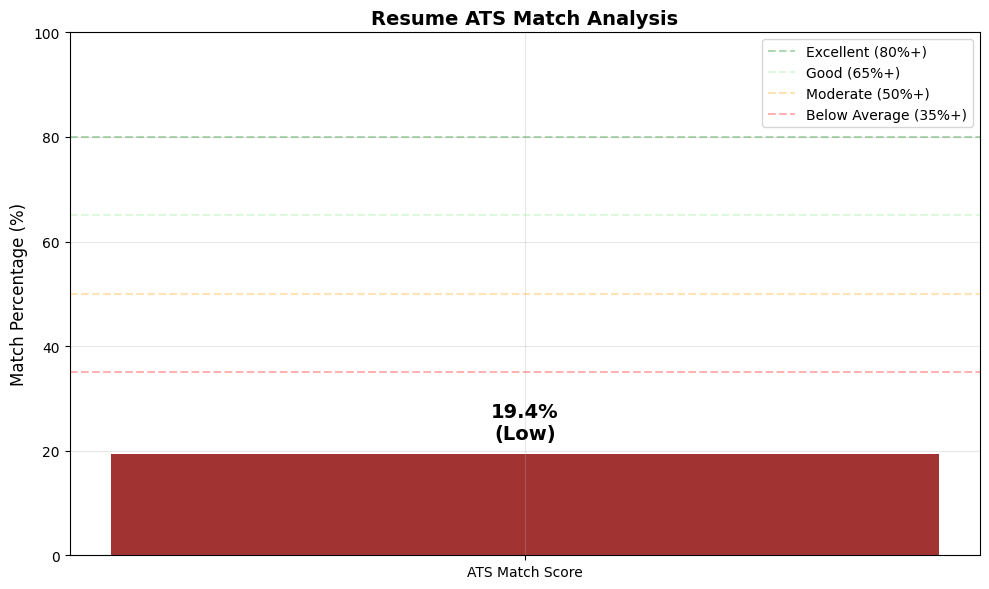


Additional Tips to Boost Your Score: 
- Use exact keywords from the job description in your resume.
- Include relevant skills in a dedicated skills section.
- Tailor your experience descriptions to match job requirements.
- Use industry-standard terminology.
- Ensure your resume is in a simple, ATS-friendly format.
- Use standard section headings (Experience, Skills, Education).
- Avoid images, tables, and complex formatting.

Temporary file 'Resume.pdf' removed. 

Analysis Complete! Good luck! 


In [37]:
# Step 3: Run the ATS Checker

def run_ats_checker():
    print("ATS Resume Checker")
    print("=" * 50)
    print("This tool analyzes how well your resume matches a job description.")
    print("Supported formats: PDF, DOCX, DOC")
    print("\nStep 1: Upload your resume file")
    print("Click 'Choose Files' in the dialog below to select your resume from your local machine... ")

    # Upload resume file from local machine
    uploaded_files = files.upload()

    if not uploaded_files:
        print("No file was uploaded. Please try again. ")
        return

    file_name = list(uploaded_files.keys())[0]
    print(f"Successfully uploaded: {file_name} ")

    # Extract text from resume
    try:
        resume_text = extract_resume_text(file_name)
        if not resume_text or len(resume_text.strip()) < 100:
            print("Warning: Very short resume text extracted. Please ensure your PDF/DOCX is readable. ")
            return
    except Exception as e:
        print(f"Error reading file: {e}")
        print("Please ensure you uploaded a valid PDF or DOCX file. ")
        if os.path.exists(file_name):
            os.remove(file_name)
        return

    print("\n" + "="*50)
    print("Step 2: Paste the job description below and press Enter:")
    print("(Paste the complete job posting including requirements and qualifications)")

    job_desc = input("\nJob Description: ")

    if not job_desc.strip():
        print("Job description cannot be empty. Please try again. ")
        if os.path.exists(file_name):
            os.remove(file_name)
        return

    if len(job_desc.strip()) < 50:
        print("Warning: Job description seems very short. Consider pasting the complete job posting for a better analysis. ")

    print("\nAnalyzing your resume against the job description... ")

    try:
        # Extract keywords and calculate score
        resume_keywords = extract_keywords(resume_text)
        job_keywords = extract_keywords(job_desc)
        ats_score = calculate_ats_score(resume_text, job_desc)

        # Display comprehensive results
        print("\n" + "="*60)
        print("ATS MATCH ANALYSIS RESULTS")
        print("="*60)

        print(f"\nATS Match Score: {ats_score:.2f}%")
        print(f"Score Category: {get_score_feedback(ats_score)}")

        print(f"\nKeyword Analysis:")
        print(f"- Resume keywords found: {len(resume_keywords)}")
        print(f"- Job description keywords: {len(job_keywords)}")
        print(f"- Matching keywords: {len(resume_keywords & job_keywords)}")

        matching_keywords = resume_keywords & job_keywords
        if matching_keywords:
            print(f"\nMatching skills found: {', '.join(sorted(list(matching_keywords))[:15])} ")

        print(f"\nImprovement Suggestions:")
        print(get_suggestions(resume_keywords, job_keywords))

        # Show visualization
        visualize_score(ats_score)

        # Provide additional recommendations
        print("\nAdditional Tips to Boost Your Score: ")
        if ats_score < 65:
            print("- Use exact keywords from the job description in your resume.")
            print("- Include relevant skills in a dedicated skills section.")
            print("- Tailor your experience descriptions to match job requirements.")
            print("- Use industry-standard terminology.")

        print("- Ensure your resume is in a simple, ATS-friendly format.")
        print("- Use standard section headings (Experience, Skills, Education).")
        print("- Avoid images, tables, and complex formatting.")

    except Exception as e:
        print(f"Error during analysis: {e}")

    finally:
        # Clean up uploaded file
        if os.path.exists(file_name):
            os.remove(file_name)
            print(f"\nTemporary file '{file_name}' removed. ")

    print("\n" + "="*60)
    print("Analysis Complete! Good luck! ")
    print("="*60)

# Run the ATS checker
run_ats_checker()

## Saving to GitHub

To store this notebook on GitHub:
1. Save this JSON content as `ats_matcher.ipynb`.
2. Create a GitHub repository (e.g., `ATS_Checker_Job-Description`).
3. Upload `ats_matcher.ipynb` to the repository.
4. The notebook can be opened in Colab directly from GitHub using the provided link in the first cell.

**Note**: This version runs entirely in Colab and does not require Streamlit. For a web-based version, consider deploying the Streamlit version (see previous versions of this code). Ensure resume files are text-based for accurate extraction.